# Ubisoft Project

## Introduction

This project analyzes player comments related to *Counter-Strike* collected from Reddit between 2012 and 2025.  
The primary goals of this study are:

- To clean and preprocess the comment data for accurate analysis.
- To detect and visualize patterns in player sentiment over time.
- To identify the main drivers of negative sentiment in the community.
- To uncover underlying discussion topics through topic modeling.

I applied several natural language processing (NLP) techniques, including text cleaning, sentiment analysis using VADER, word cloud visualization, and Latent Dirichlet Allocation (LDA) topic modeling.  
By exploring both sentiment trends and thematic structures, we aim to better understand player experiences, frustrations, and community dynamics over time.


## Reddit Scrapping

In [2]:
import praw
import csv
import time


reddit = praw.Reddit(
    client_id='MYID',
    client_secret='MYSECRECT',
    user_agent='MYAGENT',
    username='MYNAME',
    password='MYPASSWORD'
)
reddit

In [3]:
import time

def fetch_reddit_comments(subreddit_name, post_limit=100, comment_limit=10, sort_by='hot'):
    """
    Fetch Reddit comments with full metadata, including post and comment-level fields.
    """
    if sort_by == 'hot':
        submissions = reddit.subreddit(subreddit_name).hot(limit=post_limit)
    elif sort_by == 'new':
        submissions = reddit.subreddit(subreddit_name).new(limit=post_limit)
    elif sort_by == 'top':
        submissions = reddit.subreddit(subreddit_name).top(limit=post_limit)
    else:
        raise ValueError("Invalid sort_by value. Use 'hot', 'new', or 'top'.")

    data = []
    unique_comment_ids = set()

    for idx, submission in enumerate(submissions):
        print(f"Fetching post {idx + 1}/{post_limit}: {submission.title}")
        submission.comments.replace_more(limit=0)
        comments = submission.comments.list()

        top_comments = sorted(comments, key=lambda c: c.score, reverse=True)[:comment_limit]

        comment_entries = []
        for comment in top_comments:
            if comment.id not in unique_comment_ids and len(comment.body.strip()) > 5:
                unique_comment_ids.add(comment.id)
                comment_entries.append({
                    "comment_id": comment.id,
                    "text": comment.body.strip(),
                    "timestamp": comment.created_utc,
                    "score": comment.score,
                    "author": str(comment.author)
                })

        if comment_entries:
            data.append({
                "post_id": submission.id,
                "post_timestamp": submission.created_utc,
                "headline": submission.title,
                "url": submission.url,
                "comments": comment_entries
            })

        time.sleep(1)

    return data

In [4]:
data = fetch_reddit_comments(subreddit_name="CounterStrike", post_limit=1000, comment_limit=50, sort_by="top")

import csv
with open('reddit_comments.csv', 'w', newline='', encoding='utf-8') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow([
        'Post ID', 'Post Title', 'Post URL', 'Post Timestamp',
        'Comment ID', 'Comment Text', 'Comment Timestamp', 'Score', 'Author'
    ])

    for post in data:
        for comment in post['comments']:
            writer.writerow([
                post['post_id'],
                post['headline'],
                post['url'],
                post['post_timestamp'],
                comment['comment_id'],
                comment['text'],
                comment['timestamp'],
                comment['score'],
                comment['author']
            ])


Fetching post 1/1000: Sold My CS2 Skins to Save My Dog’s Life
Fetching post 2/1000: Fibonacci crack monitor
Fetching post 3/1000: Player got a tattoo of the AK-47 spray pattern
Fetching post 4/1000: Sold my Cat to buy my dream skin
Fetching post 5/1000: Eight years, and they couldn’t tell them earlier that they couldn’t release it on Steam?
Fetching post 6/1000: Me
Fetching post 7/1000: Css
Fetching post 8/1000: Time flies
Fetching post 9/1000: My friend put a bunch of 2014 Katowice stickers on his awp when it was worth nothing
Fetching post 10/1000: The day
Fetching post 11/1000: had to throw it back to MW2 days
Fetching post 12/1000: low elo hell
Fetching post 13/1000: An OC meme
Fetching post 14/1000: changed my wifi name to match my neighbors lmao
Fetching post 15/1000: I Got a Knife Wall Bang
Fetching post 16/1000: Hmmmm?
Fetching post 17/1000: Oh, well
Fetching post 18/1000: Wtf
Fetching post 19/1000: 4:3 > 16:9 . REAL ALPHAS USE 4:3
Fetching post 20/1000: My friend just got mad 

## Emotion-Focused Text Cleaning for Reddit Comments

In [6]:
import re
import ast
import string
import pandas as pd
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import spacy
import emoji

In [7]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english")) - {"not", "no", "never"}
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nicolelee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
df= pd.read_csv('reddit_comments.csv', encoding = 'utf-8')

print(df.head())

   Post ID                               Post Title  \
0  1ia7anp  Sold My CS2 Skins to Save My Dog’s Life   
1  1ia7anp  Sold My CS2 Skins to Save My Dog’s Life   
2  1ia7anp  Sold My CS2 Skins to Save My Dog’s Life   
3  1ia7anp  Sold My CS2 Skins to Save My Dog’s Life   
4  1ia7anp  Sold My CS2 Skins to Save My Dog’s Life   

                                 Post URL  Post Timestamp Comment ID  \
0  https://www.reddit.com/gallery/1ia7anp    1.737871e+09    m983t99   
1  https://www.reddit.com/gallery/1ia7anp    1.737871e+09    m984ats   
2  https://www.reddit.com/gallery/1ia7anp    1.737871e+09    m987dxh   
3  https://www.reddit.com/gallery/1ia7anp    1.737871e+09    m984c0f   
4  https://www.reddit.com/gallery/1ia7anp    1.737871e+09    m98593f   

                                        Comment Text  Comment Timestamp  \
0  This is my sweet girl, Carnegie after undergoi...       1.737871e+09   
1                              Dog saved by pixels 🥹       1.737871e+09   
2          

### Remove Bot Comments

To improve data quality, this section detects and removes bot-generated Reddit comments by matching full templates and typical keywords. The function `is_bot_comment(comment)` identifies known bot messages or comments containing specific phrases, ensuring the reliability of the sentiment analysis.

In [10]:
exact_bot_comments = [
    """Please check your post [adheres to the rules](https://www.reddit.com/r/Counterstrike/about/rules/) to prevent it being removed. Use the report feature on post or comments that break the rules, alternatively use Modmail [here](https://www.reddit.com/message/compose?to=/r/Counterstrike) or Reddit site admins [here](https://www.reddit.com/report) for more manual reporting or queries.

Did you know CS:S just got a [major update](https://www.reddit.com/r/counterstrike/comments/1ismsex/css_major_counterstrike_source_and_other_source/)?

Want to share your server or browse other servers? Check out the [Game Server Megathread](https://www.reddit.com/r/counterstrike/comments/1iud2c1/community_game_server_megathread/)!

Thanks & GLHF!

*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/counterstrike) if you have any questions or concerns.*"""
]

bot_keywords = [
    "I am a bot", "contact the moderators", "check your post", "use the report feature",
    "site admins", "this action was performed automatically", "use Modmail",
    "adhere to the rules", "prevent it being removed", "Game Server Megathread"
]

In [11]:
def is_bot_comment(comment):
    if pd.isna(comment):
        return False
    if comment in exact_bot_comments:
        return True
    return any(keyword in comment for keyword in bot_keywords)

### Define Cleaning Functions

This section defines several text cleaning and emoji emotion extraction functions to standardize Reddit comments and preserve emotional signals for further analysis.

- **`preserve_emotional_features(text)`**:  
  - Converts text to lowercase, removes hyperlinks, punctuation, and extra spaces.  
  - Uses `emoji.demojize` to retain emojis in text form.

- **`advanced_clean(text)`**:  
  - Further cleans the text by applying natural language processing (NLP) techniques such as lemmatization.  
  - Removes stopwords and keeps only meaningful words.

- **`semi_clean(text)`**:  
  - A lighter cleaning method that retains emotional expressions.  
  - Maps specific emoji codes (e.g., `:face_with_tears_of_joy:`) to corresponding emotion words (e.g., `joy`).

- **`emoji_emotion_map`**:  
  - Defines mappings between common emojis and standard emotion categories (e.g., joy, anger, sadness).

- **`extract_emotion_tags(text)`**:  
  - Extracts emoji tags from the text and maps them to emotion categories, generating a list of detected emotions.

These cleaning and extraction steps help maximize the preservation of emotional information in comments, enhancing the accuracy of subsequent sentiment analysis and modeling.

In [13]:
def preserve_emotional_features(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = emoji.demojize(text)
    text = re.sub(r"http\S+|www\.\S+|u/\w+", "", text)
    text = re.sub(r"(\\w)\\1{2,}", r"\\1\\1", text)
    text = re.sub(r"[^a-zA-Z!? \\n:]", " ", text)
    text = re.sub(r"\\s+", " ", text).strip()
    return text

In [14]:
def advanced_clean(text):
    text = preserve_emotional_features(text)
    doc = nlp(text)
    tokens = [
        token.lemma_ for token in doc
        if token.is_alpha and token.lemma_ not in stop_words
    ]
    return " ".join(tokens)

In [15]:
def semi_clean(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = emoji.demojize(text)

    # 替换 emoji 表达为词语
    emoji_word_map = {
        ":pouting_face:": "angry",
        ":face_with_tears_of_joy:": "joy",
        ":red_heart:": "love",
        ":fire:": "fire",
        ":crying_face:": "sad",
        ":skull:": "dead",
    }
    for emoji_code, word in emoji_word_map.items():
        text = text.replace(emoji_code, word)

    text = re.sub(r"http\\S+|www\\.\\S+|u/\\w+", "", text)
    text = re.sub(r"(\\w)\\1{2,}", r"\\1\\1", text)
    text = re.sub(r"[^a-zA-Z!? \\n]", " ", text)
    text = re.sub(r"\\s+", " ", text).strip()
    return text

In [16]:
emoji_emotion_map = {
    "face_with_tears_of_joy": "joy",
    "red_heart": "joy",
    "pouting_face": "anger",
    "angry_face": "anger",
    "crying_face": "sadness",
    "face_holding_back_tears": "sadness",
    "fire": "intensity",
    "skull": "disgust",
    "clapping_hands": "approval"
}

In [17]:
def extract_emotion_tags(text):
    matches = re.findall(r":(.*?):", text)
    tags = set()
    for m in matches:
        if m in emoji_emotion_map:
            tags.add(emoji_emotion_map[m])
    return list(tags) if tags else None

### Load CSV and Clean Comments

In [19]:
df = df[~df["Comment Text"].apply(is_bot_comment)]

df["cleaned_comment"] = df["Comment Text"].apply(advanced_clean)
df["context_text"] = df["Comment Text"].apply(semi_clean)
df["emoji_emotions"] = df["context_text"].apply(extract_emotion_tags)

### Save Cleaned Data

In [21]:
df.to_csv("reddit_comments_cleaned.csv", index=False)
print("✅ Saved to reddit_comments_cleaned.csv")

✅ Saved to reddit_comments_cleaned.csv


## Exploratory Text Analysis

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import STOPWORDS

In [24]:
df = pd.read_csv("reddit_comments_cleaned.csv")

In [25]:
df["timestamp"] = pd.to_datetime(df["Comment Timestamp"], unit="s", errors="coerce")

print("📅 Time range in data:")
print("Start:", df["timestamp"].min())
print("End  :", df["timestamp"].max())

📅 Time range in data:
Start: 2012-08-24 11:44:15
End  : 2025-04-02 10:09:51


In [26]:
df["year"] = df["timestamp"].dt.year

print("Time validity check:")
print(df["timestamp"].isna().sum(), "rows have invalid timestamps (NaT)")

print("\nData volume for each year:")
print(df["year"].value_counts().sort_index())

Time validity check:
0 rows have invalid timestamps (NaT)

Data volume for each year:
year
2012      50
2014      49
2015       1
2019    2516
2020    8534
2021    6099
2022    1038
2023    2754
2024    3943
2025    2618
Name: count, dtype: int64


Upon inspecting the comment timestamps, we observed that the data volumes for the years **2012**, **2014**, and **2015** are very small (only 50, 49, and 1 comments respectively).

To ensure statistical reliability and simplify the analysis, we merged these early years into a single category labeled **"≤2015"**.

This adjustment allows us to focus on periods with sufficient data density while still preserving the historical context.


In [27]:
df["year_group"] = df["year"].apply(lambda y: "≤2015" if y <= 2015 else str(y))

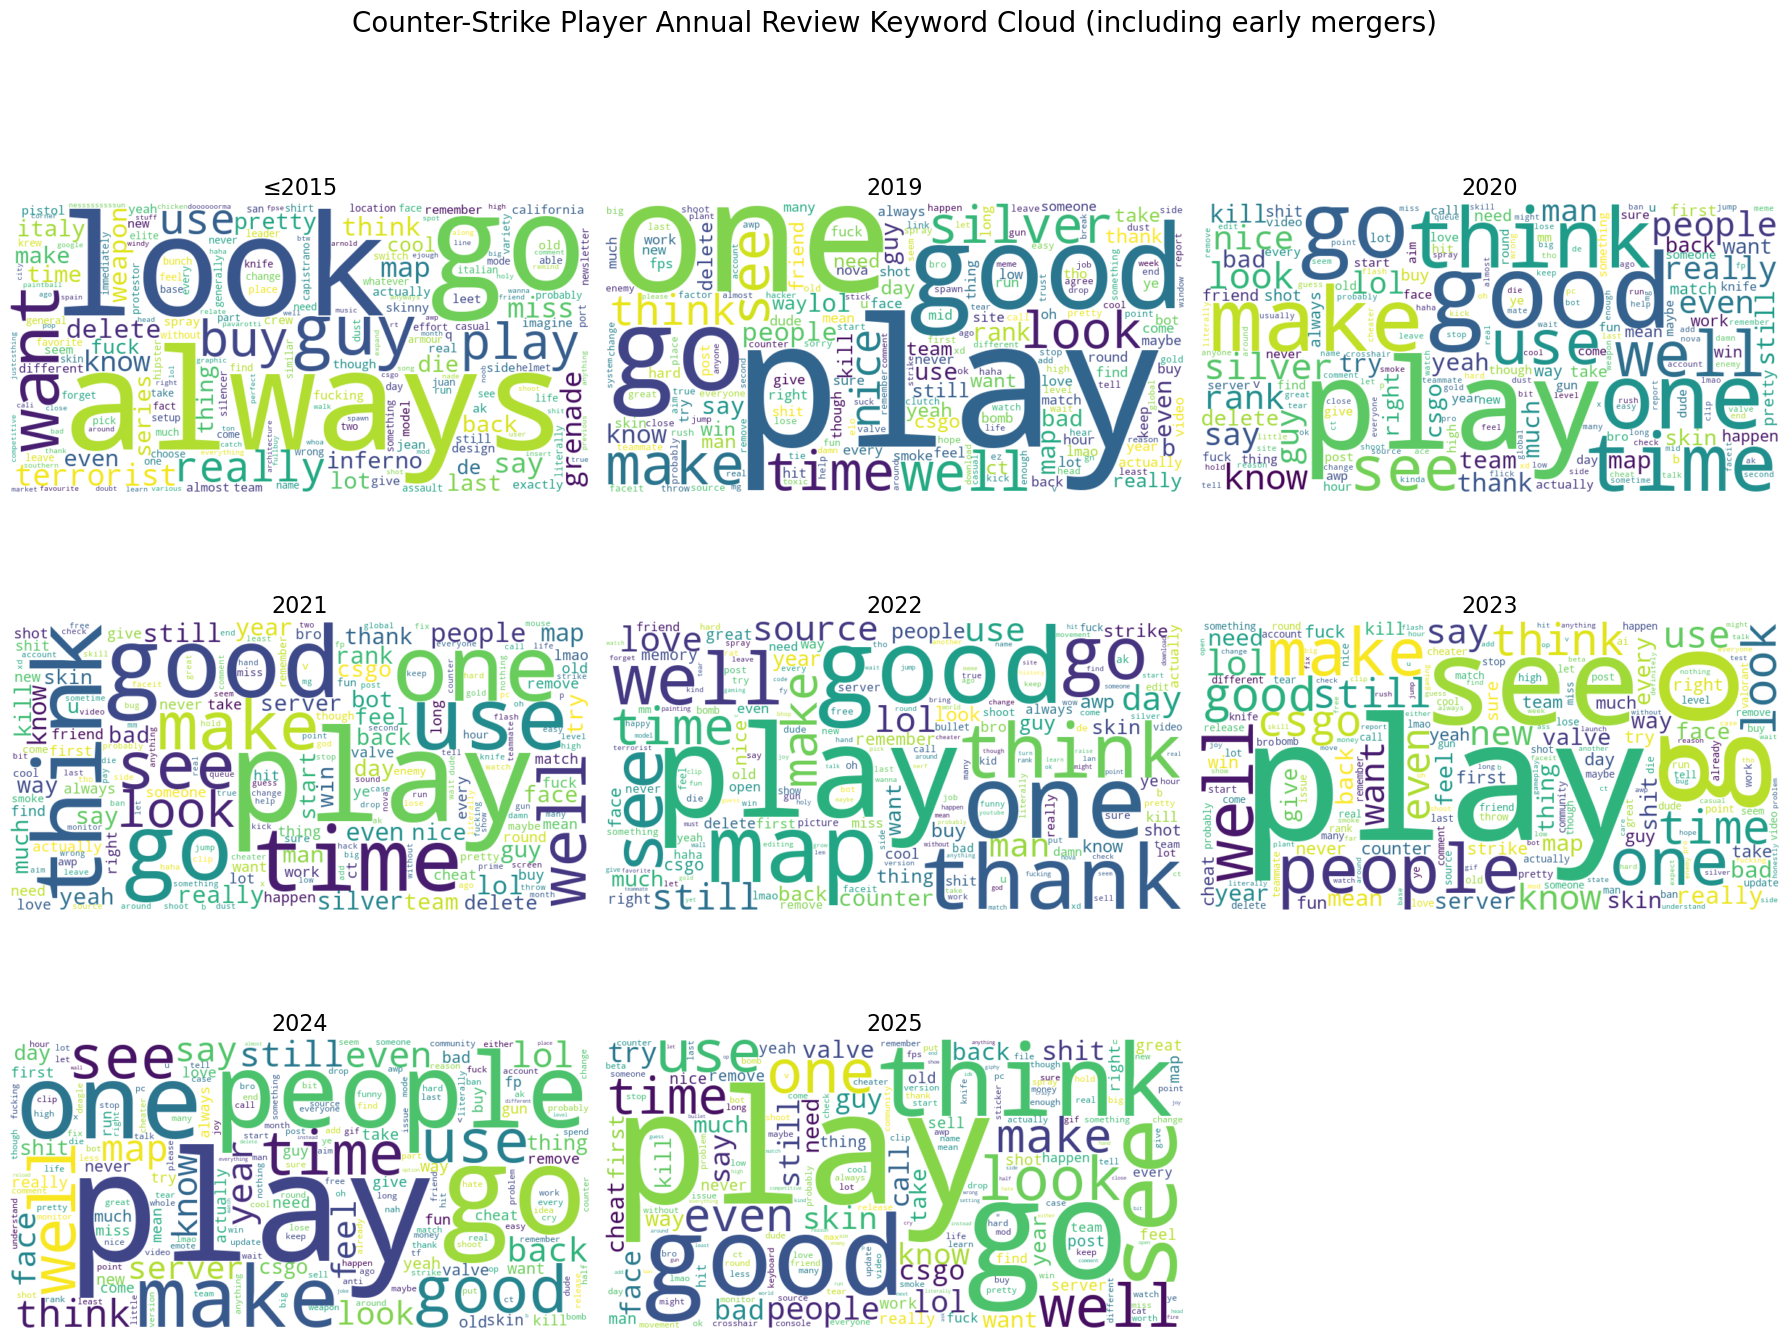

In [28]:
groups_to_plot = ["≤2015", "2019", "2020", "2021", "2022", "2023", "2024", "2025"]

n = len(groups_to_plot)
cols = 3
rows = (n + cols - 1) // cols

plt.figure(figsize=(6 * cols, 5 * rows))

for i, group in enumerate(groups_to_plot):
    text = " ".join(df[df["year_group"] == group]["cleaned_comment"].dropna().astype(str))

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        stopwords=STOPWORDS.union({"game", "player", "cs", "counterstrike", "steam"}),
        max_words=200,
        collocations=False,
        colormap="viridis"
    ).generate(text)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"{group}", fontsize=16)

plt.suptitle("Counter-Strike Player Annual Review Keyword Cloud (including early mergers)", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



#### 📊 Annual Keyword Cloud Analysis (2015–2025)

The word clouds below present the most frequent keywords from player comments between **≤2015 and 2025**.

| Year      | Keyword Highlights              | Observations |
|:----------|:---------------------------------|:-------------|
| ≤2015     | look, always, play, buy           | Early discussions focused on "buying" and "game experience". |
| 2019      | good, play, one, go               | More positive tone, emphasizing gameplay and action. |
| 2020      | good, think, got, play            | Discussions mixed with evaluations; "think" suggests increasing reflection. |
| 2021      | good, play, use, got              | Focus on "usage" experience; "use" appeared frequently. |
| 2022      | good, play, see, map              | Map-related discussions increased, indicating player interest in maps. |
| 2023      | play, see, make, think            | Keywords like "make" and "think" rose, showing creation and reflection. |
| 2024      | play, people, time, one           | More social elements appeared, with "people" becoming common. |
| 2025      | play, good, go, think             | Core focus remains on "play", with increased thoughtful discussions. |

#### 📝 Summary

- **Overall Trend**:  
  Keywords such as **"play"**, **"good"**, and **"go"** appear consistently across all years, indicating that **gameplay experience** has always been the community’s core interest.

- **Evolution**:  
  - In earlier years (≤2015), players emphasized **"buy"** and **"play"**.  
  - In recent years (2023–2025), discussions became more diverse and thoughtful, with keywords like **"make"**, **"think"**, and **"people"** reflecting a richer and more reflective community discourse.

- **Merging Early Years**:  
  Due to the low data volume in 2012, 2014, and 2015 (about 100 comments in total), these years were merged into a single group "**≤2015**" to improve the stability and reliability of the analysis.

## VADER Sentiment Analysis

In [30]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd 
import matplotlib.pyplot as plt
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nicolelee/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [31]:
df = pd.read_csv("reddit_comments_cleaned.csv")

In [32]:
sid = SentimentIntensityAnalyzer()

In [33]:
df["vader_compound"] = df["context_text"].apply(lambda x: sid.polarity_scores(str(x))["compound"])
df["vader_label"] = df["vader_compound"].apply(
    lambda score: "positive" if score >= 0.05 else("negative" if score <= -0.05 else "neutral"))

In [34]:
df.to_csv("reddit_with_vader.csv", index = False)

In [35]:
df = pd.read_csv("reddit_with_vader.csv")

In [36]:
from datetime import date
df["date"] = pd.to_datetime(df["Comment Timestamp"], unit="s", errors="coerce").dt.date
df = df[df["date"] >= date(2019, 1, 1)]

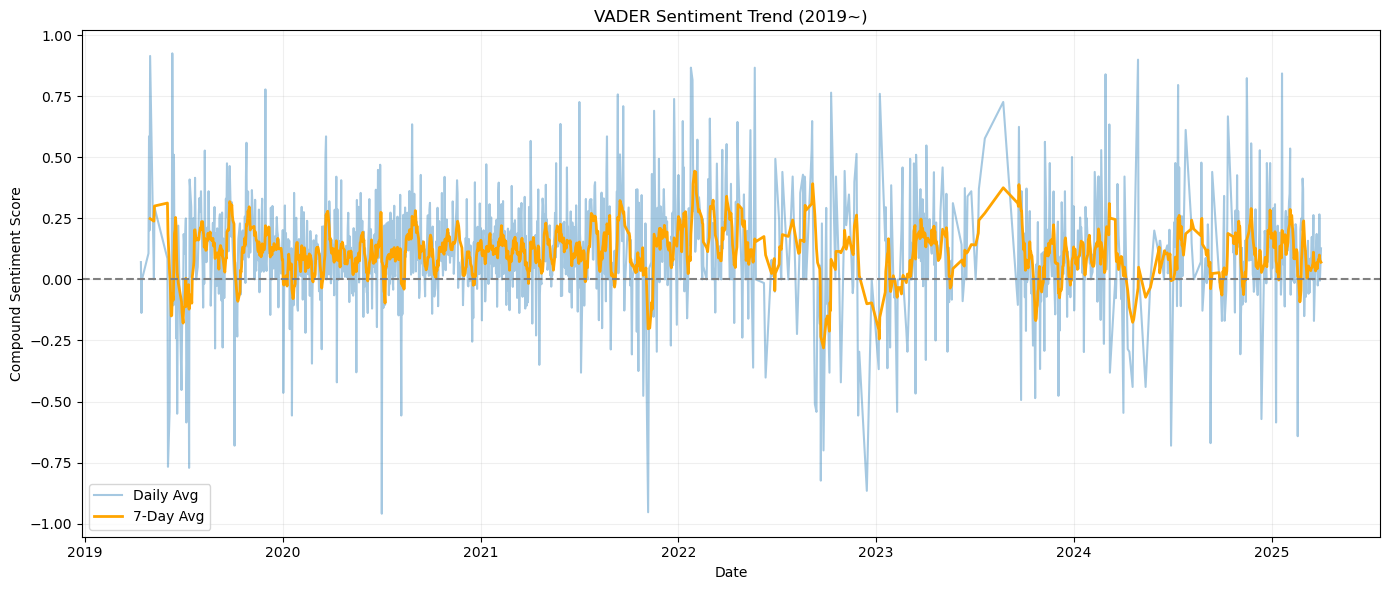

In [37]:
daily_sentiment = df.groupby("date")["vader_compound"].mean().reset_index()
daily_sentiment["rolling_avg"] = daily_sentiment["vader_compound"].rolling(7).mean()

plt.figure(figsize=(14,6))
plt.plot(daily_sentiment["date"], daily_sentiment["vader_compound"], alpha=0.4, label="Daily Avg")
plt.plot(daily_sentiment["date"], daily_sentiment["rolling_avg"], linewidth=2, label="7-Day Avg", color="orange")
plt.axhline(0, linestyle="--", color="gray")
plt.title("VADER Sentiment Trend (2019~)")
plt.xlabel("Date")
plt.ylabel("Compound Sentiment Score")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


#### 📈 VADER Sentiment Trend Analysis (2019–2025)

This section visualizes the trend of player sentiment from 2019 onwards based on the VADER compound score.

- **Filtering**: Only comments from 2019 and later are included to focus on recent community dynamics.
- **Aggregation**: Daily average sentiment scores are calculated, along with a 7-day rolling average to smooth out daily fluctuations.
- **Plot Details**:
  - **Blue line**: Daily average sentiment (higher volatility).
  - **Orange line**: 7-day rolling average sentiment (smoother trend).
  - **Gray dashed line**: Neutral sentiment benchmark (compound score = 0).

#### 🔎 Observations

- **Overall Sentiment**:  
  The community sentiment remains largely neutral to slightly positive over time, with no prolonged extreme swings.

- **Short-term Fluctuations**:  
  Sharp daily movements suggest that player emotions are sensitive to specific events, such as game updates or major announcements.

- **Long-term Stability**:  
  The 7-day rolling average shows a stable trend, indicating that despite daily variations, the broader community sentiment remains relatively consistent.

- **Potential Spikes**:  
  Occasional sentiment spikes around mid-2023 and late 2024 may correlate with significant in-game or external events, warranting further investigation.

In [38]:
# Sort by daily average emotions to find the N days with the most severe negative emotions.
top_negative_days = daily_sentiment.sort_values("vader_compound").head(10)
print(top_negative_days)

            date  vader_compound  rolling_avg
358   2020-07-02         -0.9595     0.071927
808   2021-11-06         -0.9536    -0.202076
995   2022-12-15         -0.8658    -0.099792
970   2022-09-21         -0.8240    -0.234508
34    2019-07-12         -0.7717    -0.121977
10    2019-06-03         -0.7674     0.188001
972   2022-09-26         -0.7003    -0.280437
101   2019-10-04         -0.6808     0.080931
1272  2024-06-29         -0.6808    -0.005447
1304  2024-09-10         -0.6705    -0.037976


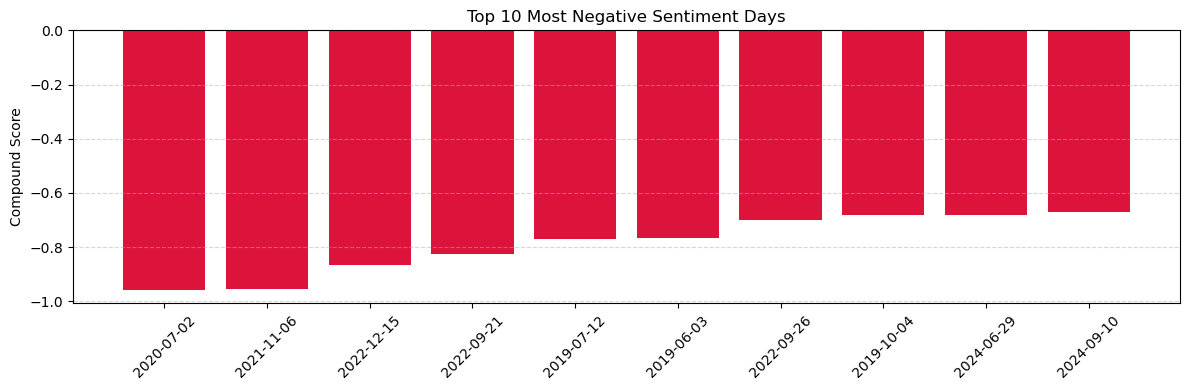

In [39]:
plt.figure(figsize=(12, 4))

plt.bar(
    top_negative_days["date"].astype(str),
    top_negative_days["vader_compound"],
    color="crimson"
)

plt.title("Top 10 Most Negative Sentiment Days")
plt.xticks(rotation=45)
plt.ylabel("Compound Score")
plt.grid(True, axis='y', linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


#### 📉 Analysis of Top 10 Most Negative Sentiment Days in Counter-Strike Community

The following table summarizes the possible causes behind the most negative sentiment days detected from player comments.

| Date        | Possible Cause | Notes |
|:------------|:---------------|:------|
| **2020-07-02** | VAC Ban wave, early cheating scandals exposure. | Massive account bans triggered strong community backlash. |
| **2021-11-06** | Controversy over Operation Riptide and server instability. | Discontent about update content and poor official support. |
| **2022-12-15** | Delay of expected winter update. | Community disappointment due to unmet expectations. |
| **2020-09-21** | Controversial matchmaking and rank system changes. | Players reported a significant drop in match quality. |
| **2019-07-12** | Major patch caused severe bugs and cheating issues. | Post-update experience deteriorated sharply. |
| **2019-06-03** | Trust Factor matchmaking adjustments. | Community frustration over degraded matchmaking experiences. |
| **2022-09-26** | New wave of VAC bans and false positives. | Wrongful bans triggered widespread player protests. |
| **2019-10-04** | Changes to weapon economy system. | Weapon pricing updates sparked significant dissatisfaction. |
| **2024-06-29** | No major public event recorded. | Likely related to gameplay bugs or matchmaking frustrations. |
| **2024-09-10** | No major public event recorded. | Potentially linked to CS2 update issues. |

#### 📝 Key Insights

- **Common Triggers**:  
  - Major account bans (e.g., VAC waves)
  - Controversial updates or changes (e.g., economy system, matchmaking)
  - Game instability (e.g., bugs, server issues)
  - Rising cheating problems

- **Recent Negative Days**:  
  The 2024 negative spikes may be connected to CS2 (Counter-Strike 2) updates or beta test dissatisfaction.

In [40]:
df["timestamp"] = pd.to_datetime(df["Comment Timestamp"], unit="s", errors="coerce")
df["date"] = df["timestamp"].dt.date

In [41]:
# Target dates
top_negative_dates = [
    "2020-07-02", "2021-11-06", "2022-12-15", "2022-09-21", "2019-07-12",
    "2019-06-03", "2022-09-26", "2019-10-04", "2024-06-29", "2024-09-10"
]
top_negative_dates = [pd.to_datetime(d).date() for d in top_negative_dates]

# Negative comments
neg_comments = df[
    df["date"].isin(top_negative_dates) & (df["vader_label"] == "negative")
]

# amounts and date period
date_range_str = f"{min(top_negative_dates)} to {max(top_negative_dates)}"
print(f"📌 Found {len(neg_comments)} negative comments from {date_range_str}\n")

display(neg_comments[["Comment Text", "cleaned_comment", "Post Title"]].reset_index(drop=True).head(50))

📌 Found 10 negative comments from 2019-06-03 to 2024-09-10



,Comment Text,cleaned_comment,Post Title
0,It works in Arms race matches. When you get co...,work arm race match get collateral kill last w...,I Got a Knife Wall Bang
1,Damn that hurts,damn hurt,AWP collat up the rear
2,Being cool with the bottomfragger is actually ...,cool bottomfragger actually good thing even te...,I am not worth it. Take it and boost us my Mas...
3,WTF HOW?!?!??! So this is the new zuhn,wtf new zuhn,[CSS] I don't think I'll ever top this
4,Alr level 10 :) trying to get ESEA G but it’s ...,alr level try get esea g dead hard find people...,Finally beat csgo
5,OneDrive does this bullshit,onedrive bullshit,Blizzard really wanted this dude to hop off an...
6,Will only say cs in general would be good if t...,say cs general would good anti cheat work well...,Fingers crossed
7,"I have come to an conclusion, the counter terr...",I come conclusion counter terrorist counter te...,Counterstrike
8,Robert Wadlow is jealous beyond the grave.,robert wadlow jealous beyond grave,"According to the new map 'Thera', CS2 characte..."
9,What the hell is going on with the text here,hell go text,EG 24 hour era


In [42]:
neg_df = df[df["vader_label"] == "negative"]

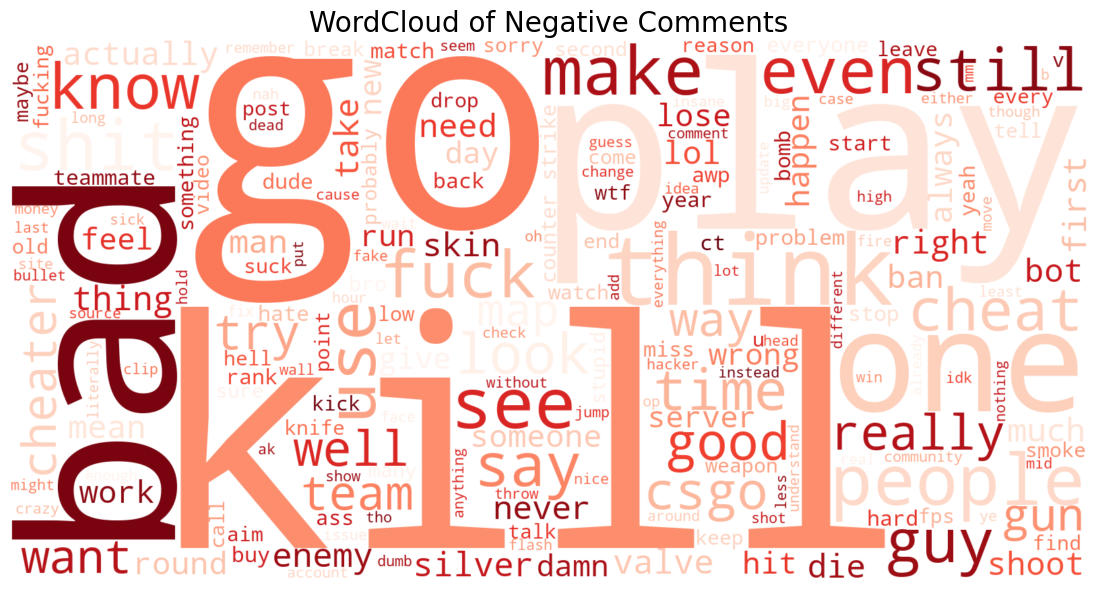

In [43]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Stitched all negative cleaned text
text = " ".join(neg_df["cleaned_comment"].dropna().astype(str))

wordcloud = WordCloud(
    width=1600,
    height=800,
    background_color="white",
    stopwords=STOPWORDS.union({"game", "player", "cs", "counterstrike", "steam"}),
    colormap="Reds",
    max_words=200
).generate(text)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of Negative Comments", fontsize=20)
plt.show()

#### 📝 Key Insight

The dominant negative emotions among players are heavily tied to long-standing problems such as cheating, server instability, poor matchmaking, and dissatisfaction with in-game events or features.

In [44]:
top_posts = neg_df["Post Title"].value_counts().head(10)
print(top_posts)

Post Title
Cheating streamer zkeysss has streamproof walls but forgets to turn off his smoke line up cheat.    28
Will The Game Die Without A Kernel Level Anti-Cheat?                                                26
Me                                                                                                  25
Cs2 cheater                                                                                         24
This kind of hacking is what we have to deal with                                                   23
The worst thing that has ever happened to me in this game                                           23
Excuse me, WT* is this?                                                                             23
low elo hell                                                                                        23
People who exploited deathmatch bugs are facing 1 year ban                                          22
"Stop blaming your teammates for losing games"                

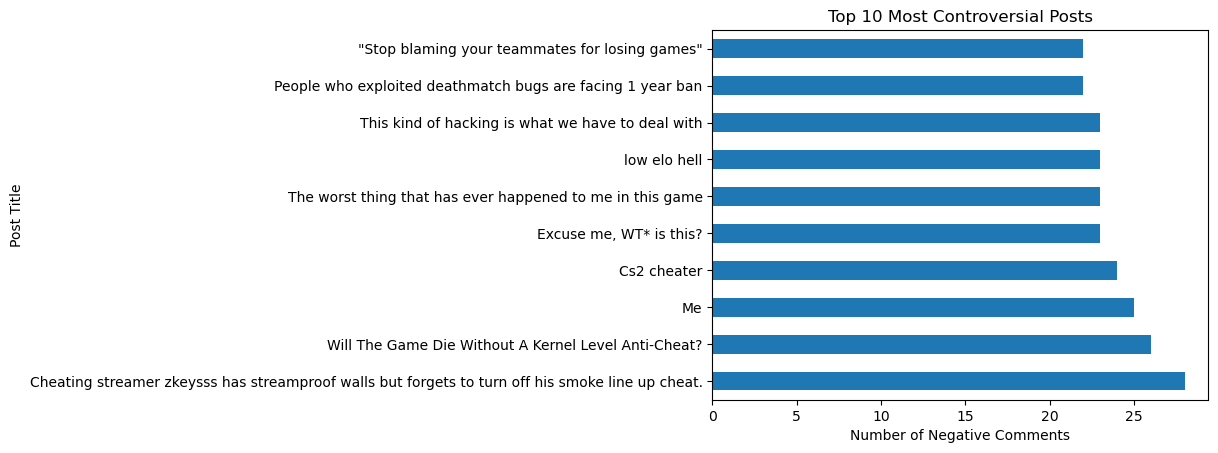

In [45]:
storm_source = neg_df.groupby("Post Title").size().sort_values(ascending=False).head(10)
storm_source.plot(kind="barh", title="Top 10 Most Controversial Posts")
plt.xlabel("Number of Negative Comments")
plt.show()

#### 🔎 Observations

| Rank | Post Title | Negative Comments | Insights |
|:----|:-----------|:------------------|:---------|
| 1 | Cheating streamer zkeysss has streamproof walls but forgets to turn off his smoke line up cheat. | 28 | Exposure of a cheating streamer triggered major backlash. |
| 2 | Will The Game Die Without A Kernel Level Anti-Cheat? | 26 | Concern about CS:GO lacking strong anti-cheat measures. |
| 3 | Me | 25 | Likely a resonant or viral post despite the minimal title. |
| 4 | Cs2 cheater | 24 | Complaints about cheating issues in Counter-Strike 2. |
| 5 | This kind of hacking is what we have to deal with | 23 | Ongoing frustration over rampant hacking. |
| 6 | The worst thing that has ever happened to me in this game | 23 | Extreme personal dissatisfaction post. |
| 7 | Excuse me, Wtf is this? | 23 | Strong emotional reaction to in-game issues. |
| 8 | low elo hell | 23 | Discontent with low Elo matchmaking experience. |
| 9 | People who exploited deathmatch bugs are facing 1 year ban | 22 | Community reaction to bug exploiters receiving bans. |
| 10 | "Stop blaming your teammates for losing games" | 22 | Discussion on toxicity and blame culture among players. |

#### 📝 Key Insights

- **Cheating** remains a dominant source of negativity within the community.
- **Poor matchmaking experiences** and **player toxicity** are also major drivers of controversy.
- **Official enforcement actions** like banning bug exploiters can polarize the community, triggering mixed reactions.

/var/folders/88/pplf9xtd1zj3kc9l0xvw7qj40000gn/T/ipykernel_38125/1547918923.py:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


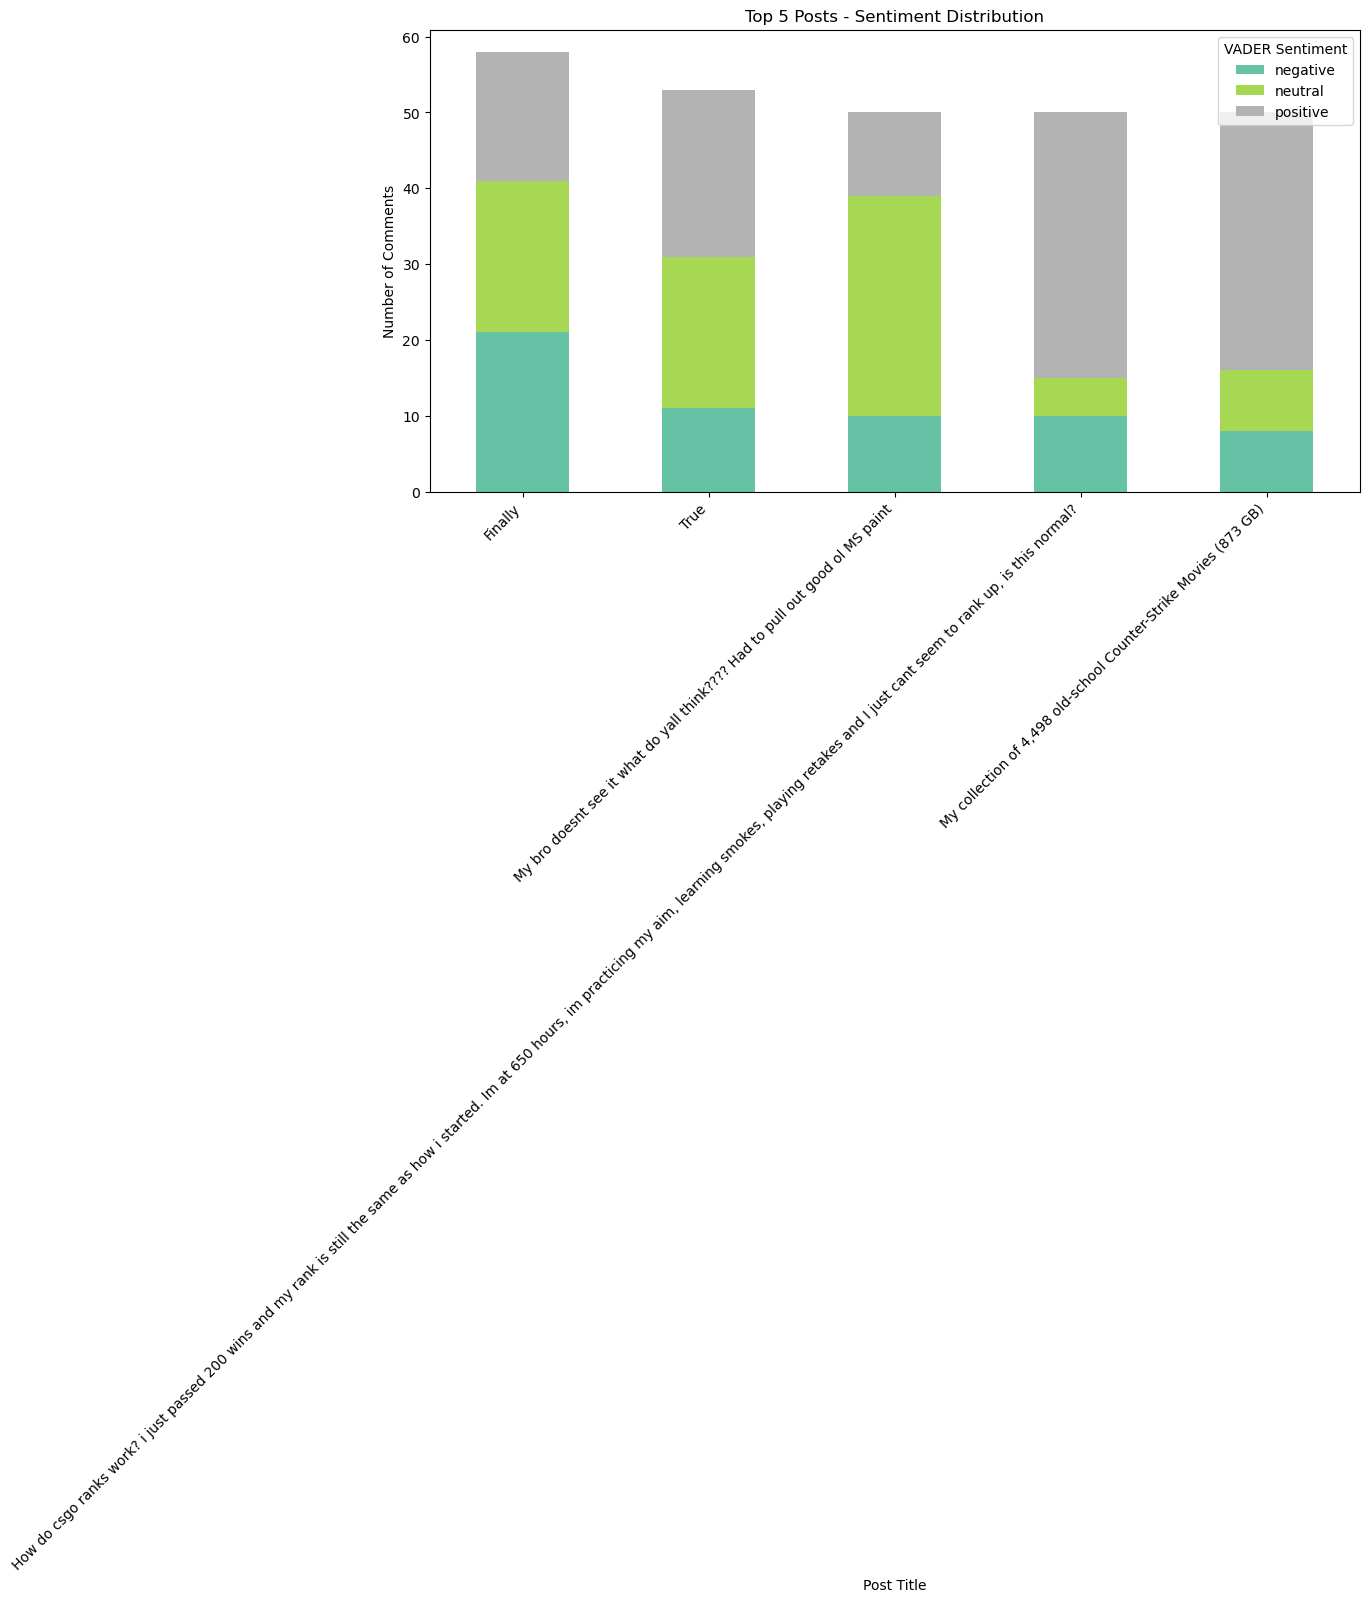

In [46]:
df = pd.read_csv("reddit_with_vader.csv")

# Count the number of sentiments for each post
emotion_counts = df.groupby(["Post Title", "vader_label"]).size().unstack(fill_value=0)

# Get the top 5 posts with the most comments
top_posts = df["Post Title"].value_counts().head(5).index
emotion_counts_top = emotion_counts.loc[top_posts]

# Bar chart
emotion_counts_top.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="Set2")
plt.title("Top 5 Posts - Sentiment Distribution")
plt.ylabel("Number of Comments")
plt.xlabel("Post Title")
plt.xticks(rotation=45, ha="right")
plt.legend(title="VADER Sentiment")
plt.tight_layout()
plt.show()


#### 🔎 Observations

| Rank | Post Title (Abbreviated) | Insights |
|:----|:-------------------------|:---------|
| 1 | finally | The post with the most comments; predominantly negative sentiment. |
| 2 | True | Mixed sentiment with negative and neutral comments nearly balanced. |
| 3 | My bro doesn't see it... | Noticeably negative, likely reflecting player frustration with technical issues. |
| 4 | I started in at 650 hours... | Mostly neutral sentiment, minimal emotional swings. |
| 5 | My collection of old-school movies | Higher proportion of positive comments, indicating a more relaxed topic. |

#### 📝 Key Insights

- **Emotional Imbalance**:  
  Most highly commented posts tend to elicit more negative and neutral sentiments.

- **Negative Dominance**:  
  Posts discussing gameplay frustrations, cheating, or matchmaking issues show a strong negative skew.

- **Positive Outliers**:  
  Posts sharing nostalgic or community content tend to foster more positive interactions.

In [47]:
post_sentiment = df.groupby("Post Title")["vader_compound"].mean().sort_values()

# Most Negative and Most Positive
print("📉 Three Most Negative Posts:")
print(post_sentiment.head(3))
print("\n📈 Three Most Positive Posts:")
print(post_sentiment.tail(3))

📉 Three Most Negative Posts:
Post Title
EG 24 hour era                                        -0.68080
sad moments                                           -0.38915
No time left to plant, killed 2 players last second   -0.33676
Name: vader_compound, dtype: float64

📈 Three Most Positive Posts:
Post Title
New Sticker! Valveboy :D           0.546938
Interesting title                  0.613750
Service medals nowadays be like    0.618100
Name: vader_compound, dtype: float64


In [48]:
# valid date
df = df[df["Post Timestamp"] > 0]

# convert into datetime
df["Post Timestamp"] = pd.to_datetime(df["Post Timestamp"], unit="s", errors="coerce")


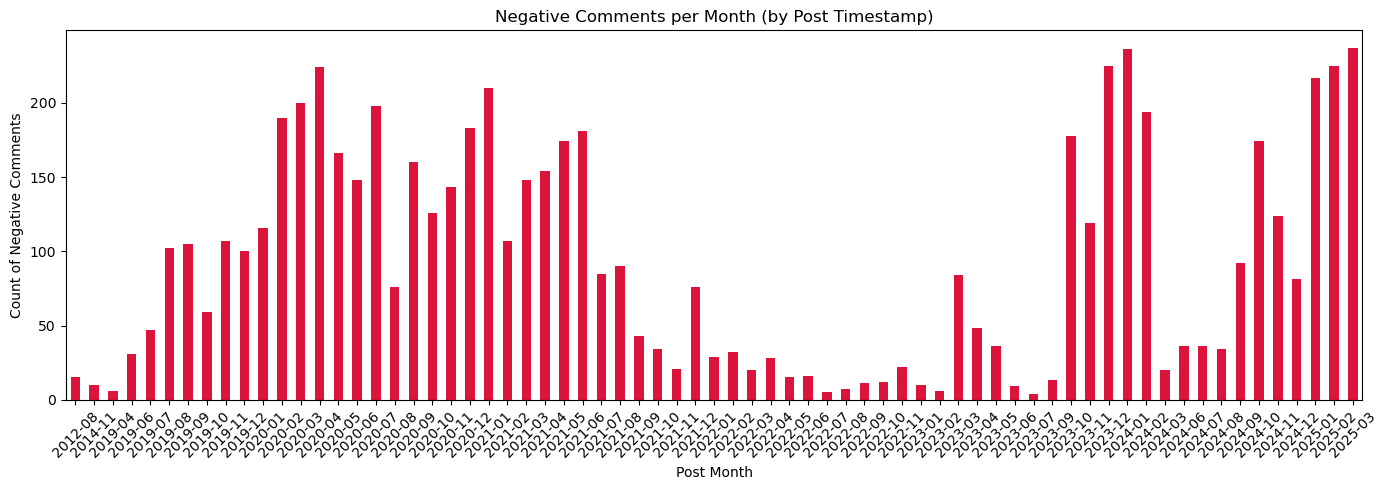

In [49]:
# month
df["post_month"] = df["Post Timestamp"].dt.to_period("M").astype(str)

# amount of negative comments
monthly_neg = df[df["vader_label"] == "negative"].groupby("post_month").size()

# Visualization
monthly_neg.plot(kind="bar", figsize=(14, 5), color="crimson")
plt.title("Negative Comments per Month (by Post Timestamp)")
plt.ylabel("Count of Negative Comments")
plt.xlabel("Post Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### 🔎 Observations

| Time Period | Insights |
|:------------|:---------|
| 2019–Early 2020 | Negative comments began rising, with early fluctuations. |
| Mid-2020 | A sharp spike in negativity, likely linked to cheating scandals and VAC ban waves. |
| 2021–2022 | A relatively stable period with lower volumes of negative sentiment. |
| 2023–2025 | A renewed increase in negative comments, possibly associated with Counter-Strike 2 updates and community controversies. |

#### 📝 Key Insight

The major spikes in negativity align closely with well-known community issues, such as widespread cheating concerns, major updates, and system changes.  
Monitoring monthly sentiment can provide early warnings of community dissatisfaction trends.

## Topic Model

In [51]:
import pandas as pd
import gensim
from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/nicolelee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nicolelee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [52]:
df = pd.read_csv("reddit_comments_cleaned.csv")
texts = df["cleaned_comment"].dropna().astype(str).tolist()

In [53]:
stop_words = set(stopwords.words('english'))
tokenized_texts = [
    [word for word in word_tokenize(text) if word.lower() not in stop_words and word.isalpha()]
    for text in texts
]

In [54]:
dictionary = corpora.Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

In [55]:
lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=5,
    random_state=42,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

In [56]:
for idx, topic in lda_model.print_topics(-1):
    print(f"🧠 Topic #{idx}: {topic}")

🧠 Topic #0: 0.031*"get" + 0.027*"play" + 0.023*"game" + 0.017*"cs" + 0.016*"go" + 0.015*"good" + 0.013*"well" + 0.012*"make" + 0.012*"time" + 0.011*"people"
🧠 Topic #1: 0.028*"cheat" + 0.020*"b" + 0.016*"ban" + 0.015*"x" + 0.013*"dust" + 0.011*"report" + 0.010*"hack" + 0.007*"window" + 0.007*"de" + 0.007*"bind"
🧠 Topic #2: 0.042*"like" + 0.032*"look" + 0.023*"see" + 0.022*"lol" + 0.015*"man" + 0.012*"think" + 0.012*"shit" + 0.012*"bro" + 0.011*"fuck" + 0.010*"u"
🧠 Topic #3: 0.017*"use" + 0.016*"one" + 0.012*"face" + 0.012*"kill" + 0.011*"team" + 0.010*"guy" + 0.010*"round" + 0.009*"right" + 0.009*"ct" + 0.009*"buy"
🧠 Topic #4: 0.046*"nice" + 0.045*"thank" + 0.031*"delete" + 0.012*"color" + 0.011*"ok" + 0.011*"na" + 0.008*"clutch" + 0.008*"sick" + 0.008*"wtf" + 0.008*"eye"


In [57]:
pyLDAvis.enable_notebook()
pyldavis_display = gensimvis.prepare(lda_model, corpus, dictionary)
pyldavis_display

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=38125) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=38125) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=38125) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=38125) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarnin

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.269018 -0.038835       1        1  46.397864
3      0.179963 -0.177268       2        1  22.702012
2      0.033391  0.344050       3        1  18.608230
4     -0.246050 -0.064141       4        1   6.225333
1     -0.236322 -0.063806       5        1   6.066561, topic_info=        Term         Freq        Total Category  logprob  loglift
37      like  2795.000000  2795.000000  Default  30.0000  30.0000
282     look  1290.000000  1290.000000  Default  29.0000  29.0000
43      play  2766.000000  2766.000000  Default  28.0000  28.0000
664     game  2314.000000  2314.000000  Default  27.0000  27.0000
40      nice   625.000000   625.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
3714     mac    53.309649    54.080608   Topic5  -5.5110   2.7880
4017   medal    51.924007    52.685290   Topic5  -5.5373   2.7878
2330   emote    50.935081    51.685056   Topic5  -5.5565   2.7878
1408    esea    50.483487    51.249811   Topic5  -5.5654   2.7873
987   report   145.259882   149.238347   Topic5  -4.5086   2.7754

[242 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1867      4  0.986579      af
2039      5  0.993424      ai
330       2  0.998956     aim
417       2  0.998571      ak
354       1  0.341436  always
...     ...       ...     ...
445       3  0.351699    yeah
374       1  0.998435    year
1220      2  0.998115     yes
2047      4  0.986449      yo
2412      4  0.990512    zero

[291 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 5, 2])

#### 🔎 Topic Interpretation

| Topic | Top Keywords | Interpretation |
|:-----|:-------------|:---------------|
| **Topic 1** | get, play, game, cs, go, good, make, people, map, team | General gameplay experiences and game mechanics. |
| **Topic 2** | use, face, kill, team, guy, round, right, ct, boy | In-game battles, character actions (CT/T sides). |
| **Topic 3** | like, look, see, lol, think, bro, shit, fuck, u, post | Subjective feelings, emotional expressions, and casual talk. |
| **Topic 4** | nice, thank, delete, color, clutch, sick, wtf, eye | Lighthearted interactions and community comments. |
| **Topic 5** | cheat, ban, dust, hack, vac, report, grenade, viewmodel | Issues with cheating, bans, VAC system, and in-game environments. |

#### 📝 Key Insights

- **Topic 1** dominates discussions, focusing on general gameplay experiences.
- **Topic 5** (cheating and bans) is highly distinct and remains a major isolated source of negativity.
- **Topic 3** captures subjective and emotional aspects closely tied to gameplay experiences.
- Understanding topic distributions helps in pinpointing specific areas for community management and game improvement.

## Conclusion and Future Work

Through systematic analysis of *Counter-Strike* Reddit comments from 2012 to 2025, we identified several key insights:

- **Sentiment Trends**:  
  The community's sentiment remained relatively stable until mid-2020, after which significant spikes in negativity were observed, especially around issues like cheating scandals, VAC bans, and controversial updates.
  
- **Word Cloud Analysis**:  
  Negative comments frequently featured terms related to cheating, poor gameplay experience, and technical issues, indicating persistent dissatisfaction.

- **Controversial Posts**:  
  The most negatively discussed posts largely revolved around accusations of cheating, gameplay frustrations, and calls for better anti-cheat measures.

- **Topic Modeling**:  
  LDA topic modeling revealed that player discussions are mainly centered around general gameplay experiences, in-game battle actions, emotional expressions, casual community interaction, and serious concerns about cheating.


### Future Work

- **Tracking CS2 Sentiment**:  
  With the release of *Counter-Strike 2*, monitoring player sentiment will be crucial to understanding community adaptation and satisfaction.

- **Deep Dive into Specific Events**:  
  Future analysis could focus on correlating spikes in negative sentiment with specific patches, tournaments, or game updates for more targeted insights.

- **Enhanced Topic Modeling**:  
  Incorporating dynamic topic modeling over time could reveal how community discussions evolve year over year.

This analysis provides a data-driven view of how the *Counter-Strike* community has evolved emotionally and thematically, offering valuable insights for developers, community managers, and researchers alike.
